### Simulation Investigation into Conditional Trend Filtering and Changepoint Detection on High-Frequency Price Process

Jason Bohne

Jason.bohne@stonybrook.edu

Applied Math and Stats Ph.D. Student 

Under Supervision of Professor Pawel Polak



In [27]:
import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt


path='/home/jbohn/jupyter/personal/'
sys.path.append(f'{path}TAQ-Query-Scripts/data')
sys.path.append(f'{path}Adaptive_Signal_Estimation_Private')

from kernel_methods.Kernel_Smoother import KernelSmoother
from kernel_methods.MomKernel_Smoother import MomKernelSmoother

from matrix_algorithms.difference_matrix import Difference_Matrix

from trend_filtering.adaptive_tf import adaptive_tf, adjust_penalty_time,cv_tf_penalty
from trend_filtering.helpers import compute_lambda_max,extract_cp


from dynamic_programming.dp_recursion import dp_solver
from dynamic_programming.cp_model_selection import generalized_cross_validation
from dynamic_programming.spline_fit import fit_linear_spline



from simulations.Conditional_Simulator import ConditionalSimulator
from simulations.Sampler import Sampler

### Prep Data

- First minute seconds of trade data for AAPL after open across availble U.S. equity exchanges
- Benchmark model for seconds however can extend to any time interval
- Results in ~1400 observations
- Preprocessed and cleaned to remove trades executed before open

In [2]:
trades=pd.read_csv(f'{path}TAQ-Query-Scripts/data/cleaned_trades.csv',index_col=0).dropna()
trades=trades[trades.index < "2020-01-02 09:30:30"]
trades=trades[trades.index> "2020-01-02 09:30:00"]
trades.index=pd.to_datetime(trades.index)


trades['Trade_Price']=np.log(trades['Trade_Price'])

trades=trades[trades['Trade_Volume'] <100000]

### Step 1; Generate Prior and Smooth using KDE

- In our analysis trade volume will be used as a prior for changes in underlying price trend however any discrete series can be utilized (realized volatility)
- Normalize time of prior to be incremented in total seconds


Smoothing Technique (KDE)
- Nonparametric method which smooths candidate point $ x_i$ as a weighted average of all observations $x_j$ where weights $w_i$ are a function of their distance in time from candidate point
- Gaussian Kernels specify function of a normal density
- Optimal bandwidth is selected either through Scott's or Silvermans.

In [3]:
original_index=trades['Trade_Volume'].index
volume_index=[(i -original_index[0]).total_seconds() for i in original_index]
volume_prior=trades['Trade_Volume'].values

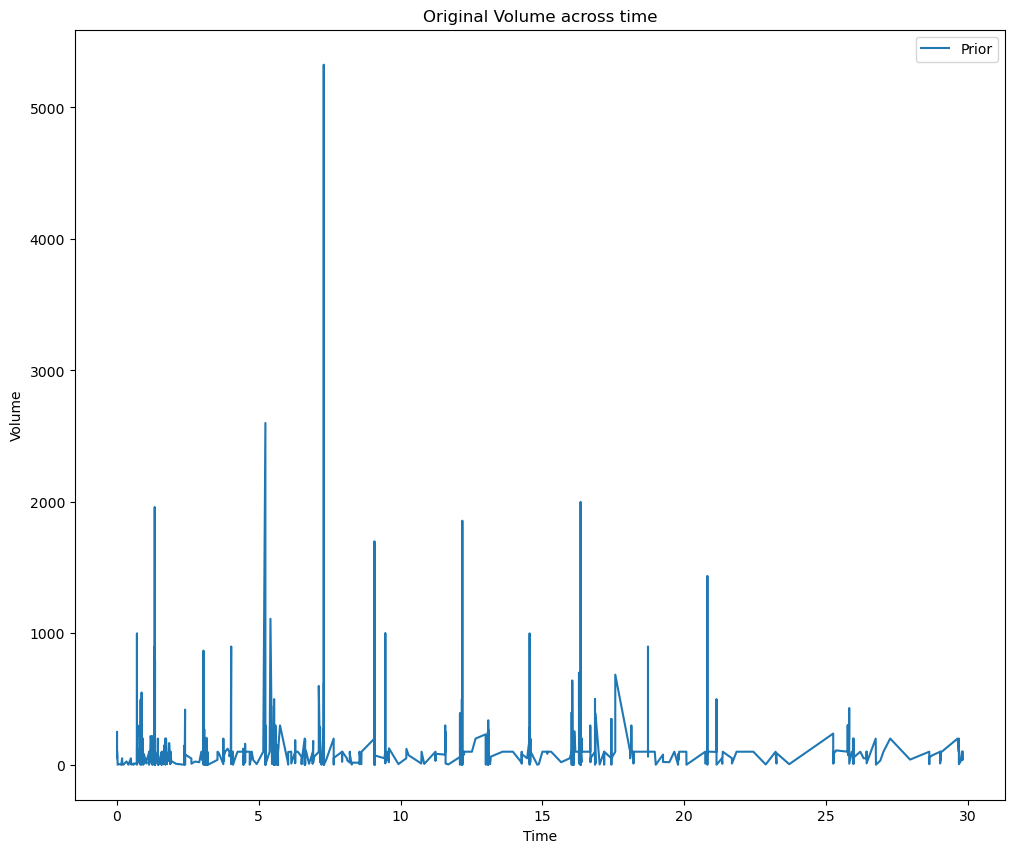

In [4]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
plt.plot(volume_index,volume_prior,label="Prior")
plt.legend()

In [5]:
smooth_kernel=KernelSmoother(volume_index,volume_prior,bandwidth_style=0)
fitted_kernel_matirx=smooth_kernel.fit()


In [6]:
smooth=smooth_kernel.smooth_series(fitted_kernel_matirx)

In [7]:
mom_smooth=MomKernelSmoother(smooth_kernel)
mom_smooth_estimate=mom_smooth.fit_mom_kde()


 OOS MSE for 1 blocks is 24096773.0


KeyboardInterrupt: 

In [ ]:
mom_smooth_estimate

array([80.04985473, 80.04416374, 80.01796459, ..., 55.4668441 ,
       55.46731993, 55.46731993])

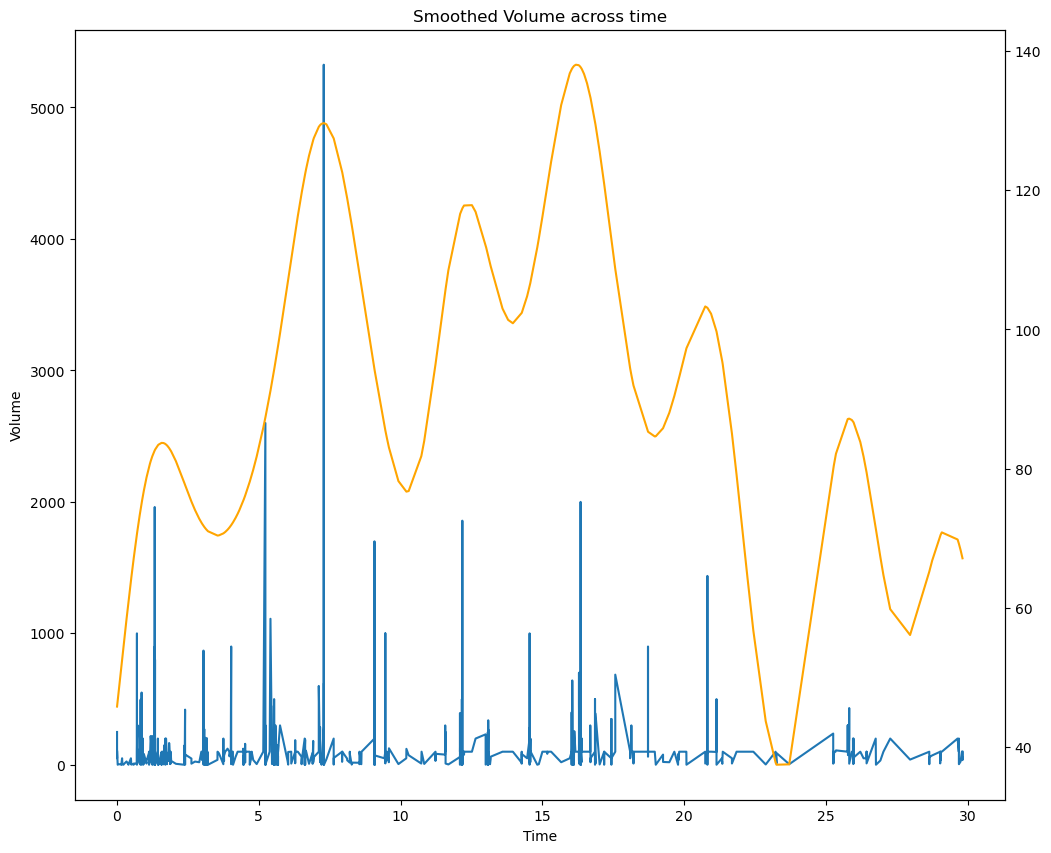

In [7]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Smoothed Volume across time")
plt.ylabel("Volume")
plt.xlabel("Time")
ax.plot(volume_index,volume_prior,label="Original")
ax2=ax.twinx()
ax2.plot(volume_index,smooth,label="Optimal Smoothed Volume",color='orange')

# ax2.plot(volume_index,mom_smooth_estimate,label="Optimal MOM Smoothed Volume",color='green')
# ax.legend()
# ax2.legend()


### Step 2 ; Simulate True Underlying Trend (Piecewise Linear and Constant)

- Label true changepoints based on some criteria (max, local peaks, etc.)
- Each change in underlying series is sampled from a normal distribution of variance prespecified 
- Interpretation is that most consecutive values will be piecewise linear with small noise; with sparse jumps arising from larger variance 


In [8]:
prior=volume_prior
sim_style='piecewise_linear'
label_style='k_maxima'
k_points=10
n_sims=10000
underling_dist='normal'

sim=ConditionalSimulator(prior,sim_style,label_style,k_points,underling_dist,n_sims=n_sims)

In [9]:
import time

start=time.time()

true_linear=sim.simulate()
eval_true_linear=sim.evaluate_within_sample(sim.cp_index,true_linear)

end=time.time()
print(f"Simulation and Evaluation for {n_sims} piecewise linear samples took {end-start} seconds")

Simulation and Evaluation for 10000 piecewise linear samples took 0.30101847648620605 seconds


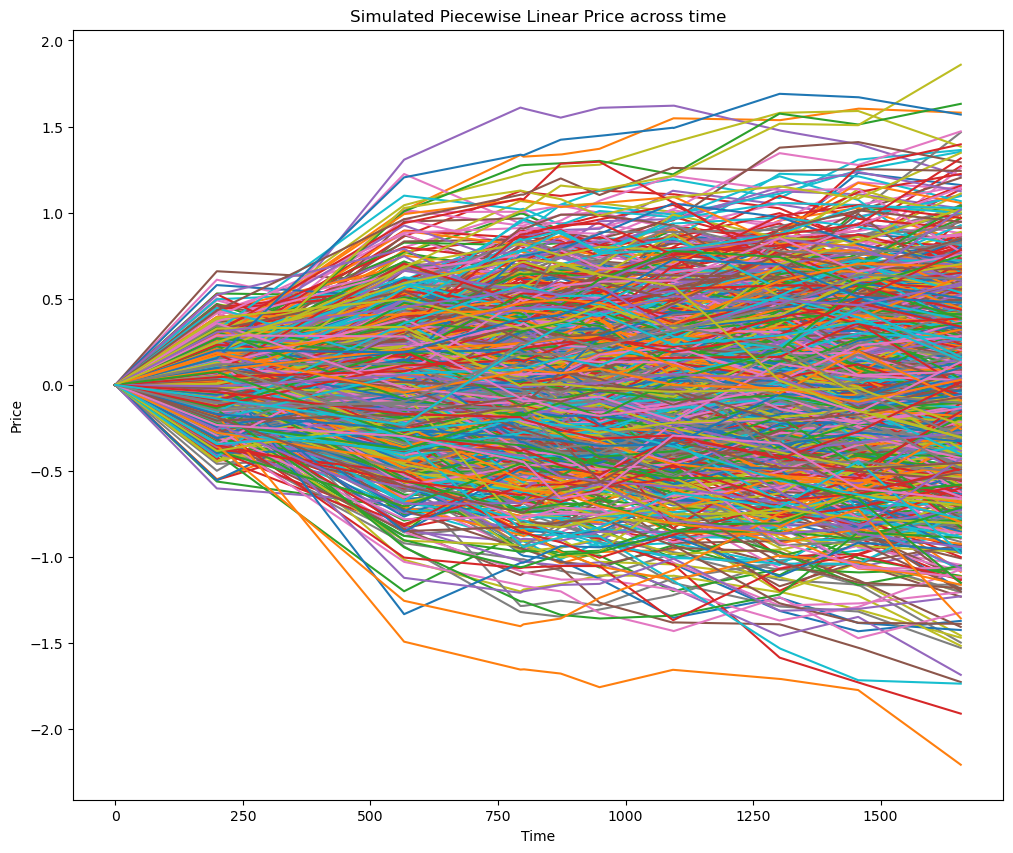

In [10]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Simulated Piecewise Linear Price across time")
plt.ylabel("Price")
plt.xlabel("Time")

for i in range(0,1000):
    ax.plot(eval_true_linear[i,:])


In [11]:
prior=volume_prior
sim_style='piecewise_constant'
label_style='k_maxima'
k_points=10
n_sims=10000
underling_dist='normal'

sim=ConditionalSimulator(prior,sim_style,label_style,k_points,underling_dist,n_sims=n_sims)

In [12]:
import time

start=time.time()

true_constant=sim.simulate()
eval_true_constant=sim.evaluate_within_sample(sim.cp_index,true_constant)

end=time.time()
print(f"Simulation and Evaluation for {n_sims} piecewise constant samples took {end-start} seconds")

Simulation and Evaluation for 10000 piecewise constant samples took 0.3868370056152344 seconds


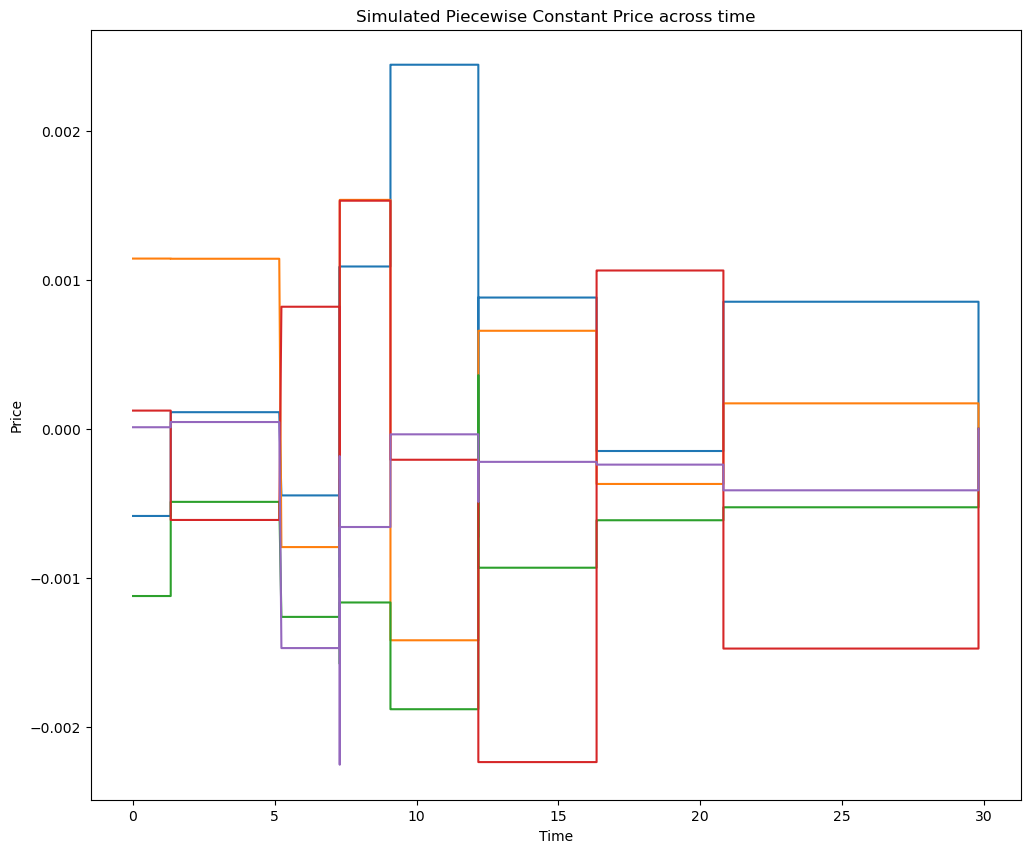

In [13]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Simulated Piecewise Constant Price across time")
plt.ylabel("Price")
plt.xlabel("Time")

for i in range(0,5):
    ax.plot(volume_index,eval_true_constant[i,:])

### Step 4; Utilize Sampler Class to generate bulk samples off true processes

In [14]:
dist='normal'

sampler=Sampler(distribution=dist)

n_samples=10000
scale=0.1
start=time.time()

samples=sampler.sample(eval_true_linear,scale=scale)

end=time.time()
print(f"Sampling {n_samples} samples from a {dist} distribution took {end-start} seconds")

Sampling 10000 samples from a normal distribution took 1.8714299201965332 seconds


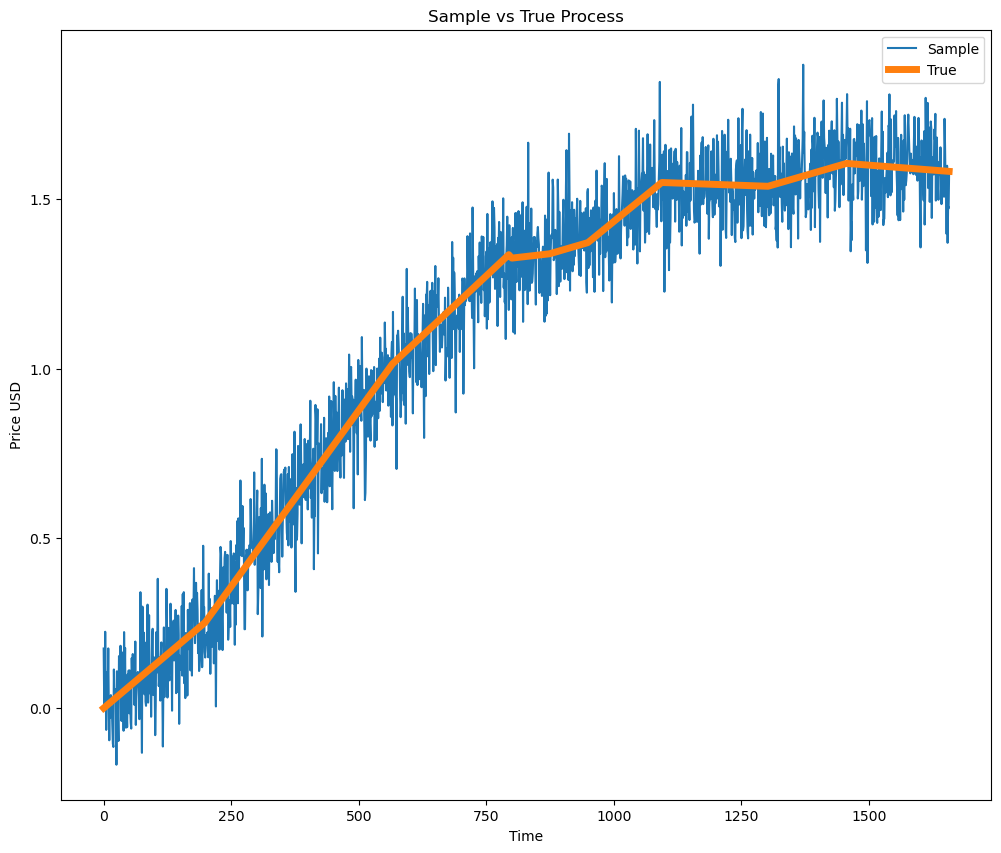

In [15]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(samples[1],label='Sample')
plt.plot(eval_true_linear[1],label='True',lw=5)
plt.xlabel("Time")
plt.ylabel("Price USD")
plt.title("Sample vs True Process")
plt.legend()

### Numerical Results 1; L1 trend filtering 

- Given the simulated path from step 5; we wish to apply L1 trend filtering to the problem
- Incorporates irregular spacing between observations
- Constrains our estimator to be piecewise linear 
- Here the penalty is set to the optimal constant determined via cross validation
    - Some lambda values in cross validation do not lead to convergence 

In [16]:
def compute_lambda_max(n,k=2):
    """Computes the maximum lambda value via inversion of banded difference matrix """
    
    start_time=time.time()
    diff_mat=Difference_Matrix(n,k)

    DDT_inv=diff_mat.DDT_inv
    end_time=time.time()

    print(f"Inverting Sparse Difference Matrix  of length {n} took {end_time-start_time} seconds")
    lambda_max = np.sqrt(DDT_inv.diagonal().max())

    return lambda_max



In [17]:
lambda_max=compute_lambda_max(2500,2)




Inverting Sparse Difference Matrix  of length 2500 took 1.1383821964263916 seconds


In [18]:


lambda_grid=np.geomspace(0.001,lambda_max,20)

optimal_lambda,optimal_error=cv_tf_penalty(samples[1].reshape(-1,1),volume_index,lambda_grid,verbose=False)

print(f"Optimal Lambda is {optimal_lambda} and Optimal Error is {optimal_error}")


Duality Gap is [[57.83771069]]
Duality Gap is [[32.38247819]]
Duality Gap is [[12.86278256]]
Duality Gap is [[5.39615432]]
Duality Gap is [[3.98208679]]
Duality Gap is [[3.02707625]]
Duality Gap is [[2.4006081]]
Duality Gap is [[2.00317198]]
Duality Gap is [[1.5557115]]
Duality Gap is [[1.42315662]]
Duality Gap is [[1.2398564]]
Duality Gap is [[1.10590295]]
Duality Gap is [[0.91314227]]
Duality Gap is [[0.81628502]]
Duality Gap is [[0.77114846]]
Duality Gap is [[0.70775379]]
Duality Gap is [[0.66011912]]
Duality Gap is [[0.59020584]]
Duality Gap is [[0.56499479]]
Duality Gap is [[0.52937555]]
Duality Gap is [[0.50110633]]
Duality Gap is [[0.47905329]]
Duality Gap is [[0.46007632]]
Duality Gap is [[0.42793879]]
Duality Gap is [[0.41074177]]
Duality Gap is [[0.38662066]]
maxiter exceeded
Duality Gap is [[134.36227876]]
Duality Gap is [[52.58718386]]
Duality Gap is [[15.13597284]]
Duality Gap is [[5.75059934]]
Duality Gap is [[2.89905393]]
Duality Gap is [[2.1976059]]
Duality Gap is [[1.7

In [33]:
start_time=time.time()

trend_filter_series,status,gap=adaptive_tf(samples[1].reshape(-1,1),t=volume_index,lambda_p=optimal_lambda)

end_time=time.time()
print (f"Adaptive Trend Filtering took {end_time-start_time} seconds")


Duality Gap is [[5.21759244e+08]]
pobj1: [[5.39680497e+09]], pobj2: [[5.21759244e+08]], dobj: [[0.]], gap: [[5.21759244e+08]]
Duality Gap is [[14175.78988819]]
Duality Gap is [[2823.81040634]]
Duality Gap is [[682.67765911]]
Duality Gap is [[336.36974861]]
Duality Gap is [[198.65184477]]
pobj1: [[8710.12568081]], pobj2: [[227.81726143]], dobj: [[29.16541666]], gap: [[198.65184477]]
Duality Gap is [[60.17779633]]
Duality Gap is [[2.86391829]]
Duality Gap is [[0.03723479]]
Duality Gap is [[0.01834339]]
Duality Gap is [[0.01146659]]
pobj1: [[34.50866903]], pobj2: [[34.51652913]], dobj: [[34.49720244]], gap: [[0.01146659]]
Duality Gap is [[0.00716856]]
Duality Gap is [[0.00448229]]
Duality Gap is [[0.00280334]]
Duality Gap is [[0.00175402]]
Duality Gap is [[0.00109818]]
pobj1: [[34.49830062]], pobj2: [[34.51628064]], dobj: [[34.49720244]], gap: [[0.00109818]]
Duality Gap is [[0.00068828]]
Duality Gap is [[0.00043212]]
Duality Gap is [[0.000272]]
Duality Gap is [[0.00017193]]
Duality Gap is

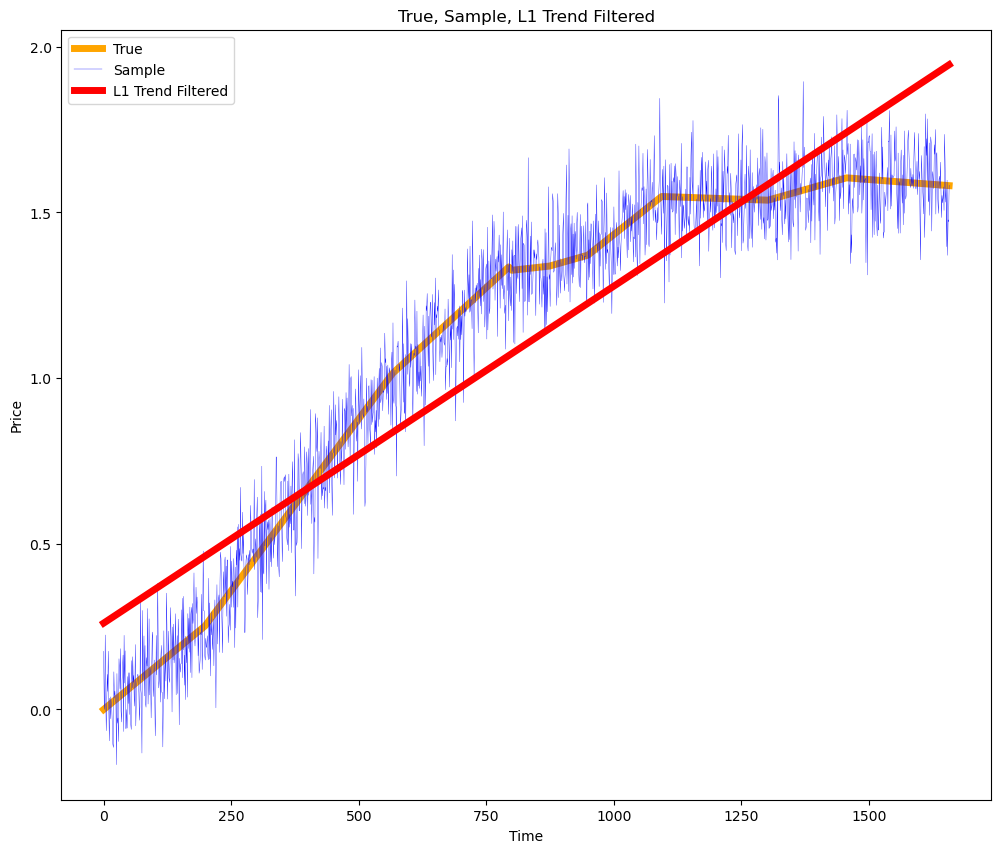

In [34]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(eval_true_linear[1],label='True', lw=5,color='orange')
plt.plot(samples[1],label='Sample',color='blue',lw=0.25)
plt.plot(trend_filter_series,label='L1 Trend Filtered',lw=5,color='red')
plt.title("True, Sample, L1 Trend Filtered")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Numerical Result 1; Conditional Adaptive L1 trend filtering  
- Estimator is piecewise linear accounting for irregular observations
- Sensitivity of estimator to changes in underlying trend is conditional on inverse of prior 
- Included explicitly as adaptive penalty (scaled by scale_factor)

In [37]:
def compute_scale_factor(robust_smooth_volume,optimal_lambda):
    """ Compute scale factor for adaptive l1 trend filtering
    """

    mean_smooth_volume=np.mean(1/robust_smooth_volume)


    scale_factor=optimal_lambda/mean_smooth_volume

    
    return scale_factor



scale_factor=compute_scale_factor(smooth,optimal_lambda) 
print(f"Optimal Scale Factor is {scale_factor}") 
adaptive_trend_filter_series,status,gap=adaptive_tf(samples[1].reshape(-1,1),t=volume_index,lambda_p=scale_factor*1/smooth[1:-1])
adaptive_trend_filter_series=adaptive_trend_filter_series.reshape(1,-1)[0][1:-1]

Optimal Scale Factor is [834736.71861783]
Duality Gap is [[5.16559734e+08]]
pobj1: [[5.33290244e+09]], pobj2: [[5.16559734e+08]], dobj: [[0.]], gap: [[5.16559734e+08]]
Duality Gap is [[13869.2261679]]
Duality Gap is [[2781.26076913]]
Duality Gap is [[632.25945195]]
Duality Gap is [[313.96021697]]
Duality Gap is [[193.81212009]]
pobj1: [[8661.17168612]], pobj2: [[221.99181526]], dobj: [[28.17969517]], gap: [[193.81212009]]
Duality Gap is [[69.25890106]]
Duality Gap is [[4.9684348]]
Duality Gap is [[0.06099]]
Duality Gap is [[0.01776349]]
Duality Gap is [[0.01110411]]
pobj1: [[34.50830655]], pobj2: [[34.51437438]], dobj: [[34.49720244]], gap: [[0.01110411]]
Duality Gap is [[0.00694195]]
Duality Gap is [[0.00434067]]
Duality Gap is [[0.00271488]]
Duality Gap is [[0.00169875]]
Duality Gap is [[0.00106358]]
pobj1: [[34.49826602]], pobj2: [[34.51420994]], dobj: [[34.49720244]], gap: [[0.00106358]]
Duality Gap is [[0.00066673]]
Duality Gap is [[0.00041865]]
Duality Gap is [[0.0002636]]
Dualit

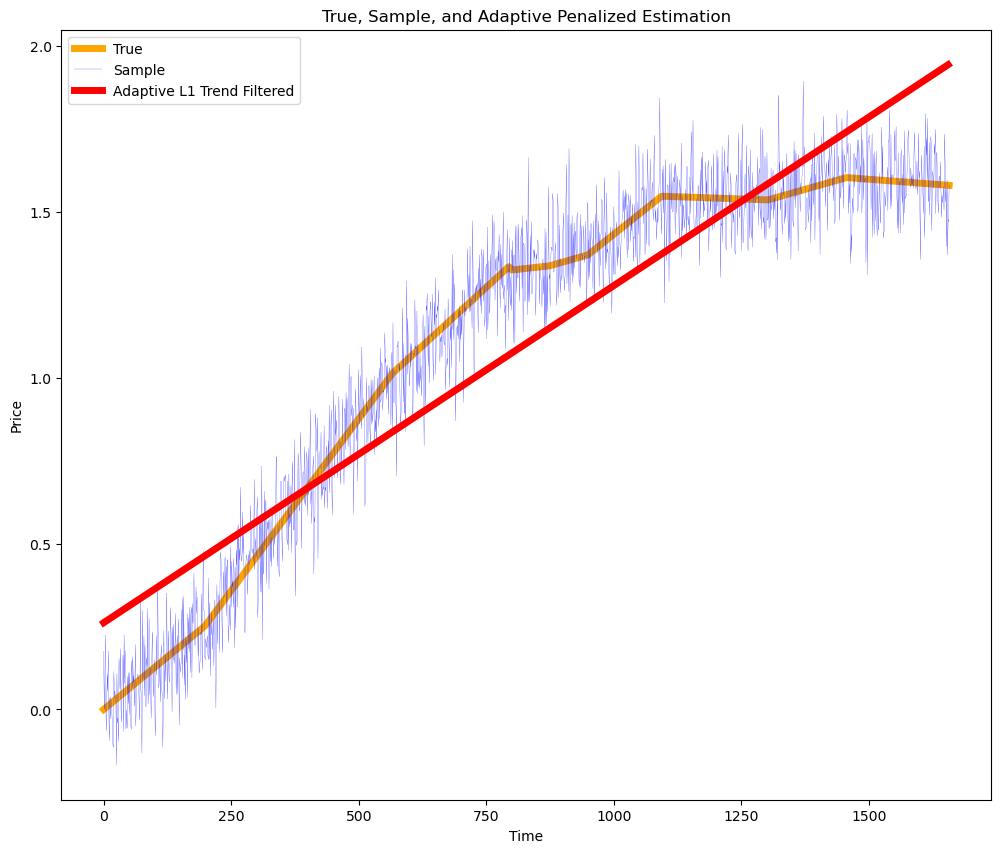

In [38]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(eval_true_linear[1],label='True', lw=5,color='orange')
plt.plot(samples[1],label='Sample',color='blue',lw=0.15)
plt.plot(adaptive_trend_filter_series,label='Adaptive L1 Trend Filtered',lw=5,color='red')
plt.title("True, Sample, and Adaptive Penalized Estimation")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Step 7; Changepoint Extraction

- As estimator is piecweise linear; changepoints can be recovered in both simulations with second order difference operator
- Recovered changepoints plotted below; marked in black
- Threshold for occurrence of changepoint is another hyperparameter to be tuned

In [36]:
changepoints=extract_cp(trend_filter_series,threshold=1e-6)
adaptive_changepoints=extract_cp(adaptive_trend_filter_series,threshold=1e-6)

ValueError: not enough values to unpack (expected 3, got 2)

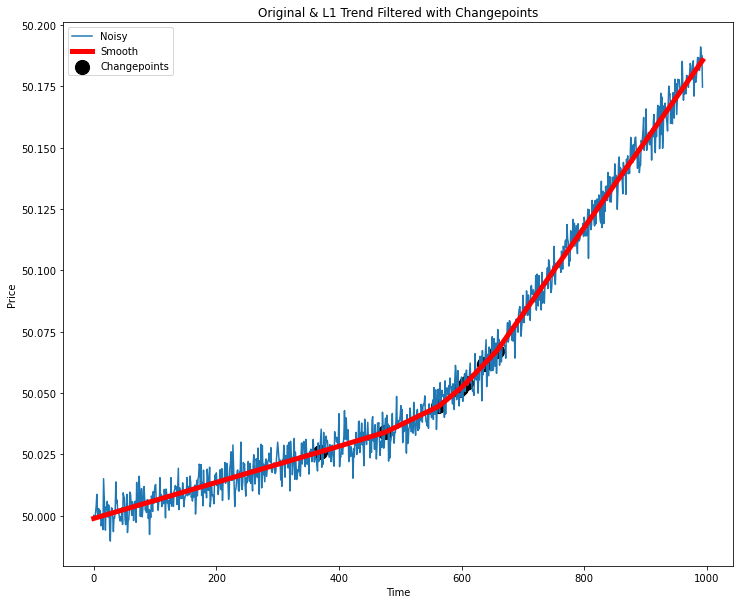

In [ ]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(samples[1],label='Noisy')
plt.plot(trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(samples[1]),1)[changepoints],trend_filter_series[changepoints],color='black',s=200,label='Changepoints')
plt.title("Original & L1 Trend Filtered with Changepoints")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

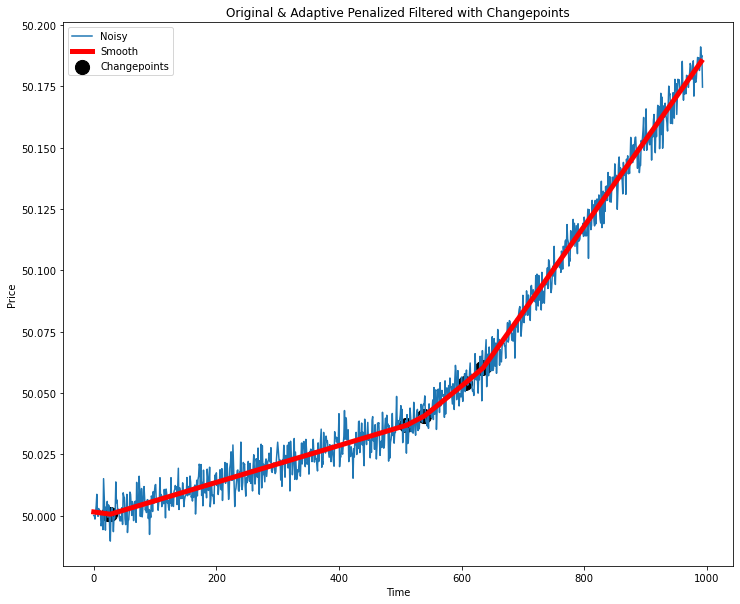

In [ ]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(samples[1],label='Noisy')
plt.plot(adaptive_trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(samples[1]),1)[adaptive_changepoints],adaptive_trend_filter_series[adaptive_changepoints],color='black',s=200,label='Changepoints')
plt.title("Original & Adaptive Penalized Filtered with Changepoints")
plt.xlabel("Time")
plt.ylabel('Price')
plt.legend()

### Pruning Candidate Set

- Given our candidate set utilize dynamic programming to recursively find optimal changepoints for fixed k_i


In [ ]:
potential_trend_cp=dp_solver(samples[1],changepoints,K_max=10)
potential_adaptive_trend_cp=dp_solver(samples[1],adaptive_changepoints,K_max=3)
potential_trend_cp


K_max must be less than or equal to the number of candidate changepoints
Candidate Indices are [  0 369 475 562 596 599 607 637 657 994]
Candidate Indices are [  0  23  26 510 539 606 634 636 994]


{1: [596],
 2: [596, 599],
 3: [596, 599, 607],
 4: [562, 596, 599, 607],
 5: [562, 596, 599, 607, 637],
 6: [475, 562, 596, 599, 607, 637],
 7: [369, 475, 562, 596, 599, 607, 637],
 8: [369, 475, 562, 596, 599, 607, 637, 657],
 0: [0]}

### Model Selection
- Utilize GCV score to determine optimal model (scaled mse)

In [ ]:
optimal_trend_cp_mse,optimal_trend_cp_gcv=generalized_cross_validation(samples[1],potential_trend_cp)
optimal_adaptive_trend_cp_mse,optimal_adaptive_trend_cp_gcv=generalized_cross_validation(samples[1],potential_adaptive_trend_cp)

opt_cp_1=potential_trend_cp[optimal_trend_cp_gcv[0][0]]
opt_cp_2=potential_adaptive_trend_cp[optimal_adaptive_trend_cp_gcv[0][0]]

print(f"Optimal Trend Changepoints are {opt_cp_1} with error {optimal_trend_cp_gcv[0][1]}")
print(f"Optimal Adaptive Trend Changepoints are  {opt_cp_2} with error {optimal_adaptive_trend_cp_gcv[0][1]}")

Optimal Trend Changepoints are [596] with error 5.257920192592592e-05
Optimal Adaptive Trend Changepoints are  [606] with error 5.291057742505125e-05


### Continuity Correction via Linear Splines
- Interpretation is that this is the best linear piecewise continuous estimator given our changepoints

In [ ]:
optimal_lin_splines=fit_linear_spline(samples[1],opt_cp_1)
optimal_adaptive_lin_splines=fit_linear_spline(samples[1],opt_cp_2)


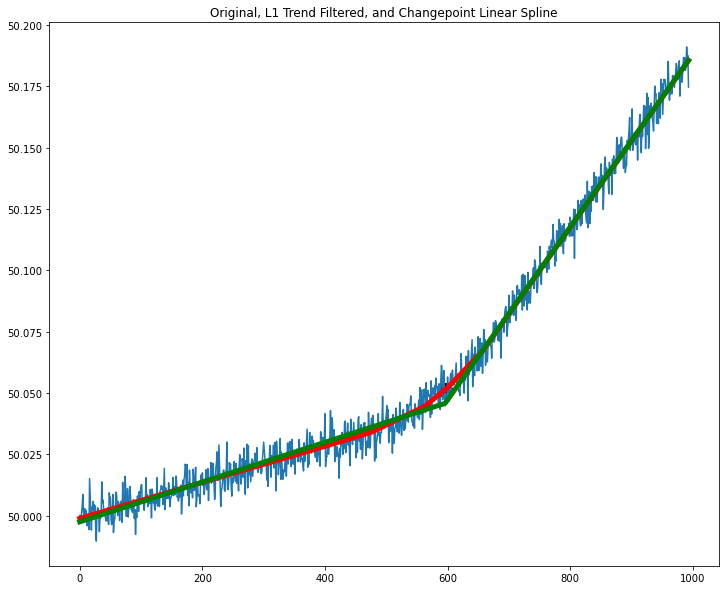

In [28]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original, L1 Trend Filtered, and Changepoint Linear Spline")
plt.plot(samples[1],label='Noisy')
plt.plot(trend_filter_series,label='Smooth',lw=5,color='red')
plt.plot(optimal_lin_splines,label='Linear Spline',lw=5,color='green')
plt.scatter(np.arange(0,len(samples[1]),1)[opt_cp_1],trend_filter_series[opt_cp_1],color='black',s=200,label='Optimal Changepoints')

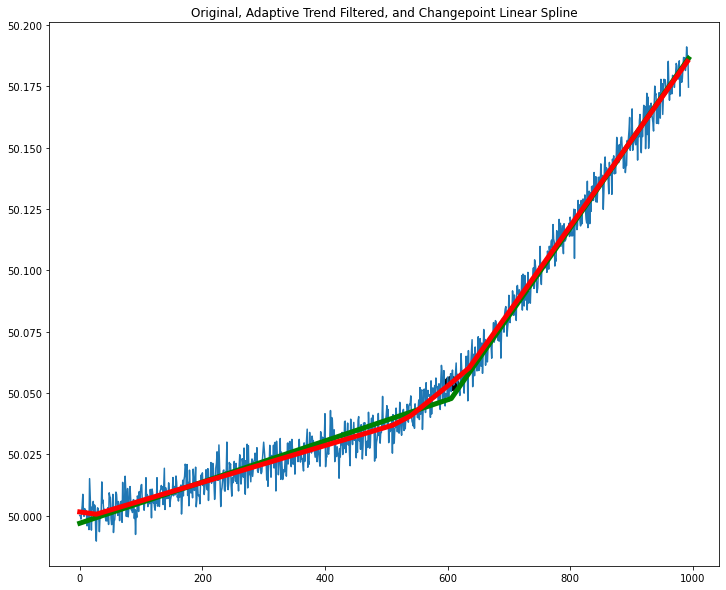

In [29]:
fig,ax=plt.subplots(figsize=(12,10))
plt.title("Original, Adaptive Trend Filtered, and Changepoint Linear Spline")
plt.plot(samples[1],label='Noisy')
plt.plot(optimal_adaptive_lin_splines,label='Linear Spline',lw=5,color='green')
plt.plot(adaptive_trend_filter_series,label='Smooth',lw=5,color='red')
plt.scatter(np.arange(0,len(samples[1]),1)[opt_cp_2],adaptive_trend_filter_series[opt_cp_2],color='black',s=200,label='Optimal Changepoints')